# Face Detection

In [176]:
from commonfunctions import *
from skimage.color import rgba2rgb
import skimage.io as io
from PIL import Image, ImageOps
import collections
from numba import jit
from joblib import Parallel, delayed
import os
import glob
import requests
import shutil
import hashlib
import tarfile
import random
# training
from datetime import datetime
import pickle
from sklearn.metrics import *
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
#gamma enhancement
def gamma(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

def gleam(values: np.ndarray) -> np.ndarray:
    return np.sum(gamma(values), axis=2) / values.shape[2]

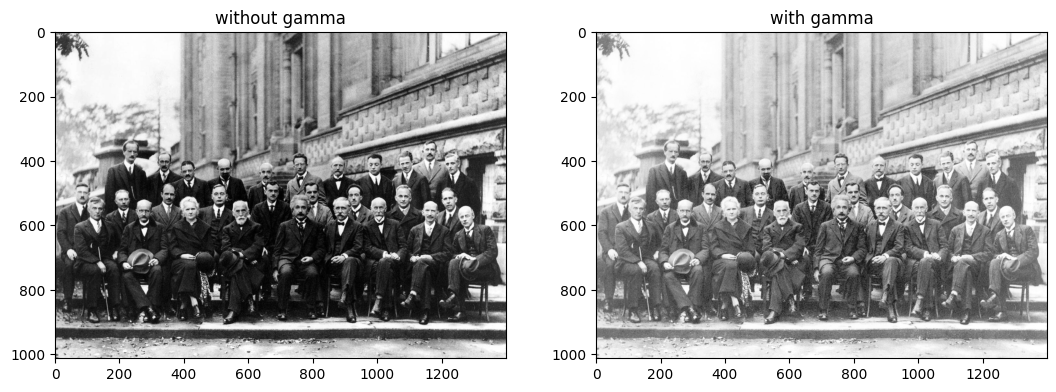

In [178]:
#read the image and convert it to greyscale
img=io.imread('The Solvay Conference.jpg')
grey_img =rgb2gray(img)

#gamma enhancement
enhanced_img= gamma(grey_img)

show_images([grey_img,enhanced_img], ["without gamma", "with gamma"])


C:\Users\PC\AppData\Local\Temp\ipykernel_13784\3641977345.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  thumbnail_image.thumbnail(target_size, Image.ANTIALIAS)


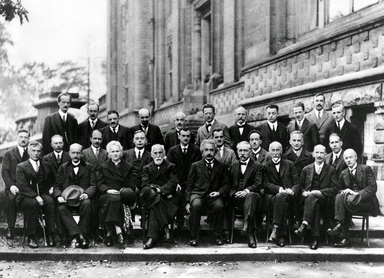

In [179]:
#will need the original image
original_image = Image.open('The Solvay Conference.jpg')
#resize the image
# according to paper, image should be resized to (384, 288)
target_size = (384, 288)
thumbnail_image = original_image.copy()
thumbnail_image.thumbnail(target_size, Image.ANTIALIAS)

    

In [180]:
#Calculate image integral
"""
In an integral image each pixel is the sum of all pixels in the original image 
that are 'left and above' the pixel.
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
"""

def get_integral_img(img: np.ndarray):
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]


In [181]:
# Calculates the sum in the rectangle specified by the given tuples
class Rectangle:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.X_corners = [x, x + width, x,          x + width]
        self.Y_corners = [y, y,         y + height, y + height]
        self.corners_coeffs   = [1, -1,        -1,         1]
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return np.sum(np.multiply(integral_image[self.Y_corners, self.X_corners], self.corners_coeffs))

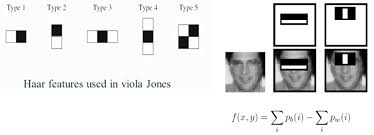

In [182]:
features_image = Image.open('features.jpg')
features_image

In [183]:
#define the features in a way they can actually be evaluated. 
class Feature2h():
    def __init__(self, x, y, width, height):
        hw = width // 2
        self.X_corners = [x,      x + hw,     x,          x + hw,
                         x + hw, x + width,  x + hw,     x + width]
        self.Y_corners = [y,      y,          y + height, y + height,
                         y,      y,          y + height, y + height]
        self.corners_coeffs   = [1,     -1,         -1,          1,
                                 -1,     1,          1,         -1]
        self.width = width
        self.height = height
        
    def __call__(self, integral_image):
        return np.sum(np.multiply(integral_image[self.Y_corners, self.X_corners], self.corners_coeffs))

In [184]:
sample_image =  np.array([
    [1, 2, 3, 4, 5], 
    [3, 5, 4, 2, 1],
    [1, 3, 2, 5, 4],
    [3, 1, 2, 4, 5],
    [4, 1, 3, 2, 4]])
sample_integral = get_integral_img(sample_image)
Feature2h(3, 1, 2, 4)(sample_integral)

-1

In [185]:
class Feature2v():
    def __init__(self, x, y, width, height):
        hh = height // 2        
        self.X_corners = [x,      x + width,  x,          x + width,
                         x,      x + width,  x,          x + width]
        self.Y_corners = [y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height]
        self.corners_coeffs   = [-1,     1,          1,         -1,
                         1,     -1,         -1,          1]
        self.width = width
        self.height = height
        
    def __call__(self, integral_image):
        return np.sum(np.multiply(integral_image[self.Y_corners, self.X_corners], self.corners_coeffs))

In [186]:
Feature2v(3, 1, 2, 4)(sample_integral)

3

In [187]:
class Feature3h():
    def __init__(self, x, y, width, height):
        tw = width // 3       
        self.X_corners = [x,        x + tw,    x,          x + tw,
                          x + tw,   x + 2*tw,  x + tw,     x + 2*tw,
                          x + 2*tw, x + width, x + 2*tw,   x + width]
        self.Y_corners = [y,        y,         y + height, y + height,
                          y,        y,         y + height, y + height,
                          y,        y,         y + height, y + height]
        self.corners_coeffs   =  [-1,       1,         1,         -1,
                                   1,      -1,        -1,          1,
                                  -1,       1,         1,         -1]
        self.width = width
        self.height = height
        
    def __call__(self, integral_image):
        return np.sum(np.multiply(integral_image[self.Y_corners, self.X_corners], self.corners_coeffs))

In [188]:
Feature3h(3, 1, 2, 4)(sample_integral)

-27

In [189]:
class Feature3v():
    def __init__(self, x, y, width, height):
        th = height // 3        
        self.X_corners = [x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width]
        self.Y_corners = [y,        y,          y + th,     y + th,
                         y + th,   y + th,     y + 2*th,   y + 2*th,
                         y + 2*th, y + 2*th,   y + height, y + height]
        self.corners_coeffs   = [-1,        1,         1,         -1,
                                  1,       -1,        -1,          1,
                                 -1,        1,         1,         -1]
        self.width = width
        self.height = height
        
    def __call__(self, integral_image):
        return np.sum(np.multiply(integral_image[self.Y_corners, self.X_corners], self.corners_coeffs))

In [190]:
Feature3v(3, 1, 2, 4)(sample_integral)

-9

In [191]:
class Feature4():
    def __init__(self, x, y, width, height):
        hw = width // 2
        hh = height // 2        
        self.X_corners = [x,      x + hw,     x,          x + hw,     
                          x + hw, x + width,  x + hw,     x + width,
                          x,      x + hw,     x,          x + hw,     
                          x + hw, x + width,  x + hw,     x + width]
        self.Y_corners =  [y,      y,          y + hh,     y + hh,     # upper row
                           y,      y,          y + hh,     y + hh,
                           y + hh, y + hh,     y + height, y + height, # lower row
                           y + hh, y + hh,     y + height, y + height]
        self.corners_coeffs   = [1,     -1,         -1,          1,          # upper row
                                 -1,     1,          1,         -1,
                                 -1,     1,          1,         -1,          # lower row
                                  1,    -1,         -1,          1]
        self.width = width
        self.height = height
        
    def __call__(self, integral_image):
        return np.sum(np.multiply(integral_image[self.Y_corners, self.X_corners], self.corners_coeffs))

In [192]:
Feature4(3, 1, 2, 4)(sample_integral)

5

In [193]:
'''
Each weak classifier is “weak” because by itself,
it cannot accurately fulfill the classification task
. Each weak classifier looks at a single feature( f ). It has both a threshold ( θ )
and a polarity ( p ) to determine the classification of a training example.

Polarity can be either -1 or 1.
When p = 1, the weak classifier outputs a positive result when f(x) < θ,
or the feature value is less than the threshold. When p = -1,
the weak classifier outputs a positive result when f(x) > θ
'''

'\nEach weak classifier is “weak” because by itself,\nit cannot accurately fulfill the classification task\n. Each weak classifier looks at a single feature( f ). It has both a threshold ( θ )\nand a polarity ( p ) to determine the classification of a training example.\n\nPolarity can be either -1 or 1.\nWhen p = 1, the weak classifier outputs a positive result when f(x) < θ,\nor the feature value is less than the threshold. When p = -1,\nthe weak classifier outputs a positive result when f(x) > θ\n'

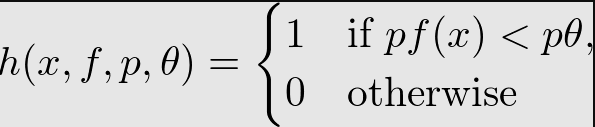

In [194]:
weak_classifier_equation = Image.open('weak_cclassifier_eq.png')
weak_classifier_equation

In [195]:
ThresholdPolarity = collections.namedtuple('ThresholdPolarity','threshold polarity')

ClassifierResult = collections.namedtuple('ClassifierResult','threshold polarity classification_error classifier')

WeakClassifier = collections.namedtuple('WeakClassifier', 'threshold polarity alpha classifier')

In [196]:
@jit
def weak_classifier(arr: np.ndarray, f, polarity, theta):
    # return 1. if (polarity * f(x)) < (polarity * theta) else 0.
    sign =np.sign((polarity * theta) - (polarity * f(arr)))
    return (sign + 1) 

@jit
def run_weak_classifier(arr: np.ndarray, w_c: WeakClassifier):
    return weak_classifier(arr=arr, f=w_c.classifier, polarity=w_c.polarity, theta=w_c.threshold)

In [197]:
'''
 compile the strong classifier out of our weak classifiers.
 
 The coefficient alpha is how much weight each weak classifier has in the final decision,
 and it is dependent on the error
 
 The weighted sum of the weak classifiers’ decisions is compared to half the sum of the alphas
 because it is akin to saying 
 “At least half the weak classifiers agree with a positive classification.”
 '''

'\n compile the strong classifier out of our weak classifiers.\n \n The coefficient alpha is how much weight each weak classifier has in the final decision,\n and it is dependent on the error\n \n The weighted sum of the weak classifiers’ decisions is compared to half the sum of the alphas\n because it is akin to saying \n “At least half the weak classifiers agree with a positive classification.”\n '

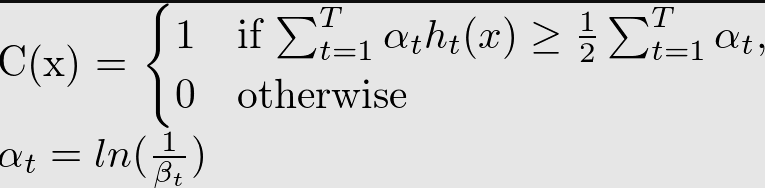

In [198]:
strong_classifier_equation = Image.open('strong_cclassifier_eq.png')
strong_classifier_equation

In [231]:
@jit
def strong_classifier(arr: np.ndarray, weak_classifiers):
    sum_hypotheses = 0.
    sum_alphas = 0.
    for c in weak_classifiers:
        sum_hypotheses += c.alpha * run_weak_classifier(arr, c)
        sum_alphas += c.alpha
    return 1 if (sum_hypotheses >= .5*sum_alphas) else 0

In [200]:
'''
 Before choosing the best classifier,
 we should normalize the weights. After choosing the best weak classifier,
 we have to update the weights with the error of the chosen weak classifier
 '''

def normalize_weights(w: np.ndarray):
    return w / w.sum()

In [201]:
'''
there is an efficient way to find the optimal threshold and polarity for a single weak classifier
using the weights.
First, sort the weights according to the feature value that they correspond to.
Now iterate through the array of weights,
and compute the error if the threshold was chosen to be that feature.
Find the threshold and polarity with the minimum error.
The possible values for a threshold are the values of the feature on each training example.
'''

'\nthere is an efficient way to find the optimal threshold and polarity for a single weak classifier\nusing the weights.\nFirst, sort the weights according to the feature value that they correspond to.\nNow iterate through the array of weights,\nand compute the error if the threshold was chosen to be that feature.\nFind the threshold and polarity with the minimum error.\nThe possible values for a threshold are the values of the feature on each training example.\n'

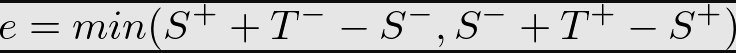

In [202]:
error_equation = Image.open('error_eq.png')
error_equation

In [203]:
def get_sums(ys: np.ndarray,normalized_weights: np.ndarray): #-> Tuple[float, float, List[float], List[float]]:
    s_minus, s_plus = 0., 0.
    t_minus, t_plus = 0., 0.
    s_minuses, s_pluses = [], []
    
    for y, w in zip(ys, normalized_weights):
        if y < .5:
            s_minus += w
            t_minus += w
        else:
            s_plus += w
            t_plus += w
        s_minuses.append(s_minus)
        s_pluses.append(s_plus)
    return t_minus, t_plus, s_minuses, s_pluses

In [204]:
@jit
def get_best_threshold(zs: np.ndarray, t_minus, t_plus, s_minuses, s_pluses) -> ThresholdPolarity:
    min_e = float('inf')
    min_z, polarity = 0, 0
    for z, s_m, s_p in zip(zs, s_minuses, s_pluses):
        error_1 = s_p + (t_minus - s_m)
        error_2 = s_m + (t_plus - s_p)
        if error_1 < min_e:
            min_e = error_1
            min_z = z
            polarity = -1
        elif error_2 < min_e:
            min_e = error_2
            min_z = z
            polarity = 1
    return ThresholdPolarity(threshold=min_z, polarity=polarity)


In [205]:
def best_threshold_polarity_steps(ys: np.ndarray, normalized_weights: np.ndarray, zs: np.ndarray):  
    # Sort according to score
    p = np.argsort(zs)
    zs, ys, normalized_weights = zs[p], ys[p], normalized_weights[p]
    
    # Determine the best threshold: build running sums
    t_minus, t_plus, s_minuses, s_pluses = get_sums(ys, normalized_weights)
    
    # Determine the best threshold: select optimal threshold.
    return get_best_threshold(zs, t_minus, t_plus, s_minuses, s_pluses) 

In [206]:
def build_feature(f, xis: np.ndarray, ys: np.ndarray, ws: np.ndarray, parallel = None) -> ClassifierResult:   
    if parallel is None:
        parallel = Parallel(n_jobs=-1, backend='threading')
    
    # Determine all feature values
    zs = np.array(parallel(delayed(f)(x) for x in xis))
    
    # Determine the best threshold
    best_threshold_polarity = best_threshold_polarity_steps(ys, ws, zs)
            
    # Determine the classification error
    classification_error = 0.
    for x, y, w in zip(xis, ys, ws):
        h = weak_classifier(x, f, best_threshold_polarity.polarity, best_threshold_polarity.threshold)
        classification_error += w * np.abs(h - y)
            
    return ClassifierResult(threshold=best_threshold_polarity.threshold, polarity=best_threshold_polarity.polarity, 
                            classification_error=classification_error, classifier=f)

In [207]:
def img_to_arr(img: Image.Image):
    return np.array(img).astype(np.float32) / 255.

def arr_to_image(values: np.ndarray) :
    return Image.fromarray(np.uint8(values * 255.))

In [208]:
def download_file(url: str, path: str):
    print('Downloading file ...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    print('Download completed.')

In [209]:
def md5(path: str, chunk_size: int=65536) -> str:
    hash_md5 = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [210]:
def untar(file_path: str, dest_path: str):
    print('Extracting file.')
    with tarfile.open(file_path, 'r:gz') as f:
        f.extractall(dest_path)
    print('Extraction completed.')

In [211]:
WINDOW_SIZE = 15
def random_crop(img: Image.Image):
    max_allowed_size = np.min(img.size)
    size = random.randint(WINDOW_SIZE, max_allowed_size)
    max_width = img.size[0] - size - 1
    max_height = img.size[1] - size - 1
    left = 0 if (max_width <= 1)  else random.randint(0, max_width)
    top  = 0 if (max_height <= 1) else random.randint(0, max_height)
    return img.crop((left,top,left+size,top+size))

In [212]:
def open_face(path: str, resize: bool=True):
    CROP_TOP = 50
    
    img = Image.open(path)
    img = arr_to_image(gamma(img_to_arr(img)[CROP_TOP:, :]))
    min_size = np.min(img.size)
    img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
    return img.convert('L')

In [213]:
def open_background(path: str, resize: bool=True) -> Image.Image:
    img = Image.open(path)
    img = arr_to_image(rgb2gray(img_to_arr(img)))
    img = random_crop(img)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
    return img.convert('L')

In [214]:
images_path = 'images'

if not os.path.exists(images_path):
    os.mkdir(images_path)

In [215]:
faces_url = 'https://www.dropbox.com/s/ubjjoo0b2wz4vgz/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz?dl=1'
faces_md5 = 'ab853c17ca6630c191457ff1fb16c1a4'

faces_archive = os.path.join(images_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz')
faces_dir = os.path.join(images_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned')

if not os.path.exists(faces_archive) or md5(faces_archive) != faces_md5:
    download_file(faces_url, faces_archive)
if not os.path.exists(faces_dir):
    untar(faces_archive, images_path)
face_image_files  = glob.glob(os.path.join(faces_dir, '**', '*.png'), recursive=True)
len(face_image_files )

37921

In [216]:
backgrounds_url = 'http://dags.stanford.edu/data/iccv09Data.tar.gz'
backgrounds_md5 = 'f469cf0ab459d94990edcf756694f4d5'

backgrounds_archive = os.path.join(images_path, 'iccv09Data.tar.gz')
backgrounds_dir = os.path.join(images_path, 'iccv09Data')

if not os.path.exists(backgrounds_archive) or md5(backgrounds_archive) != faces_md5:
    download_file(backgrounds_url, backgrounds_archive)
if not os.path.exists(backgrounds_dir):
    untar(backgrounds_archive, images_path)
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
len(background_image_files )

Download completed.


715

In [217]:
# For training, we want to sample training data.
def sample_data(p: int, n: int):
    xs = []
    xs.extend([img_to_arr(open_face(f)) for f in random.sample(face_image_files, p)])
    xs.extend([img_to_arr(open_background(f)) for f in np.random.choice(background_image_files, n, replace=True)])

    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In [218]:
image_samples, _ = sample_data(100, 100)

sample_mean = image_samples.mean()
sample_std = image_samples.std()
del image_samples

C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1076921654.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1076921654.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1489421609.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)


In [219]:
# Normalize Data 
def normalize(im, mean= sample_mean, std = sample_std):
    return (im - mean) / std

In [220]:

def sample_data_normalized(p, n, mean= sample_mean, std= sample_std):
    xs, ys = sample_data(p, n)
    xs = normalize(xs, mean, std)
    return xs, ys

# Adaptive Boosting

In [221]:
random.seed(18151210)
np.random.seed(18151210)
xs, ys = sample_data_normalized(1000, 700)

C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1076921654.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1076921654.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1489421609.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)


In [222]:
xis = np.array([get_integral_img(x) for x in xs])

# Train

In [223]:
STATUS_EVERY     = 2000
KEEP_PROBABILITY = 1./4.

def build_weak_classifiers(prefix: str, num_features, xis, ys, features, ws = None):
    if ws is None:
        m = len(ys[ys < .5])  # number of negative example
        l = len(ys[ys > .5])  # number of positive examples

        # Initialize the weights
        ws = np.zeros_like(ys)
        ws[ys < .5] = 1./(2.*m)
        ws[ys > .5] = 1./(2.*l)
    
    # Keep track of the history of the example weights.
    w_history = [ws]
    
    total_start_time = datetime.now()
    with Parallel(n_jobs=-1, backend='threading') as parallel:
        weak_classifiers = [] 
        for t in range(num_features):
            print(f'Building weak classifier {t+1}/{num_features} ...')
            start_time = datetime.now()
            
            # Normalize the weights
            ws = normalize_weights(ws)
            
            status_counter = STATUS_EVERY

            # Select best weak classifier for this round
            best_classifier = ClassifierResult(polarity=0, threshold=0, classification_error=float('inf'), classifier=None)
            for i, f in enumerate(features):
                status_counter -= 1
                improved = False

                # Python runs singlethreaded. To speed things up,
                # we're only anticipating every other feature, give or take.
                if KEEP_PROBABILITY < 1.:
                    skip_probability = np.random.random()
                    if skip_probability > KEEP_PROBABILITY:
                        continue

                result = build_feature(f, xis, ys, ws, parallel)
                if result.classification_error < best_classifier.classification_error:
                    improved = True
                    best_classifier = result

                # Print status every couple of iterations.
                if improved or status_counter == 0:
                    current_time = datetime.now()
                    duration = current_time - start_time
                    total_duration = current_time - total_start_time
                    status_counter = STATUS_EVERY
                    if improved:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(features)} {100*i/len(features):.2f}% evaluated. Classification error improved to {best_classifier.classification_error:.5f} using {str(best_classifier.classifier)} ...')
                    else:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(features)} {100*i/len(features):.2f}% evaluated.')

            # After the best classifier was found, determine alpha
            beta = best_classifier.classification_error / (1 - best_classifier.classification_error)
            alpha = np.log(1. / beta)
            
            # Build the weak classifier
            classifier = WeakClassifier(threshold=best_classifier.threshold, polarity=best_classifier.polarity, classifier=best_classifier.classifier, alpha=alpha)
            
            # Update the weights for misclassified examples
            for i, (x, y) in enumerate(zip(xis, ys)):
                h = run_weak_classifier(x, classifier)
                e = np.abs(h - y)
                ws[i] = ws[i] * np.power(beta, 1-e)
                
            # Register this weak classifier           
            weak_classifiers.append(classifier)
            w_history.append(ws)
        
            pickle.dump(classifier, open(f'{prefix}-weak-learner-{t+1}-of-{num_features}.pickle', 'wb'))
    
    print(f'Done building {num_features} weak classifiers.')
    return weak_classifiers, w_history


In [224]:
random.seed(1339)
np.random.seed(1339)
test_xs, test_ys = sample_data_normalized(5000, 5000)
test_xis = np.array([get_integral_img(x) for x in test_xs])

C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1076921654.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1076921654.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
C:\Users\PC\AppData\Local\Temp\ipykernel_13784\1489421609.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)


In [225]:

Size = collections.namedtuple('Size', 'height width')
Location = collections.namedtuple('Location','top left')

def possible_position(size, window_size = WINDOW_SIZE):
    return range(0, window_size - size + 1)

def possible_locations(base_shape: Size,window_size = WINDOW_SIZE):
    return (Location(left=x, top=y)
            for x in possible_position(base_shape.width, window_size) 
            for y in possible_position(base_shape.height, window_size))

def possible_shapes(base_shape: Size, window_size = 15) :
    base_height = base_shape.height
    base_width = base_shape.width
    return (Size(height=height, width=width)
            for width in range(base_width, window_size + 1, base_width)
            for height in range(base_height, window_size + 1, base_height))

In [226]:
feature2h = list(Feature2h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature2v = list(Feature2v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3h = list(Feature3h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3v = list(Feature3v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=3, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature4  = list(Feature4(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

features = feature2h + feature2v + feature3h + feature3v + feature4

print(f'Total number of features:     {len(features)}')

Total number of features:     24976


In [227]:
weak_classifiers_3, w_history_3 = build_weak_classifiers('3rd', 25, xis, ys, features)  # , w_history_2[-1]

Building weak classifier 1/25 ...


C:\Users\PC\AppData\Local\Temp\ipykernel_13784\3971414407.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_best_threshold" failed type inference due to: No implementation of function Function(<class 'float'>) found for signature:
 
 >>> float(Literal[str](inf))
 
There are 4 candidate implementations:
   - Of which 2 did not match due to:
   Overload in function 'Float.generic': File: numba\core\typing\builtins.py: Line 968.
     With argument(s): '(unicode_type)':
    Rejected as the implementation raised a specific error:
      NumbaTypeError: float() only support for numbers
  raised from c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\typing\builtins.py:974
   - Of which 2 did not match due to:
   Overload of function 'float': File: numba\experimental\jitclass\overloads.py: Line 124.
     With argument(s): '(unicode_type)':
    No match.

During: resolving callee type: Function(<class 'fl

t=1/25 5.37s (5.31s in this stage) 1/24976 0.00% evaluated. Classification error improved to 0.78221 using <__main__.Feature2h object at 0x000001AE09F126B0> ...
t=1/25 5.69s (5.62s in this stage) 6/24976 0.02% evaluated. Classification error improved to 0.70136 using <__main__.Feature2h object at 0x000001AE09F12020> ...
t=1/25 6.01s (5.94s in this stage) 7/24976 0.02% evaluated. Classification error improved to 0.69114 using <__main__.Feature2h object at 0x000001AE09F11ED0> ...
t=1/25 6.72s (6.65s in this stage) 17/24976 0.06% evaluated. Classification error improved to 0.68664 using <__main__.Feature2h object at 0x000001AE09F2FEE0> ...
t=1/25 7.04s (6.98s in this stage) 22/24976 0.08% evaluated. Classification error improved to 0.66807 using <__main__.Feature2h object at 0x000001AE09F2DDB0> ...
t=1/25 7.40s (7.33s in this stage) 26/24976 0.10% evaluated. Classification error improved to 0.62664 using <__main__.Feature2h object at 0x000001AE09F2F130> ...
t=1/25 18.75s (18.68s in this s

C:\Users\PC\AppData\Local\Temp\ipykernel_13784\4223121334.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "run_weak_classifier" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\PC\AppData\Local\Temp\ipykernel_13784\4223121334.py (9)

File "C:\Users\PC\AppData\Local\Temp\ipykernel_13784\4223121334.py", line 9:
def run_weak_classifier(arr: np.ndarray, w_c: WeakClassifier):
    return weak_classifier(arr=arr, f=w_c.classifier, polarity=w_c.polarity, theta=w_c.threshold)
    ^

  @jit
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "run_weak_classifier" was compiled in object mode without forceobj=True.

File "C:\Users\PC\AppData\Local\Temp\ipykernel_13784\4223121334.py", line 8:
@jit
def run_weak_classifier(arr: np.ndarray, w_c: WeakClassifier):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\PC

Building weak classifier 2/25 ...
t=2/25 2025.03s (0.33s in this stage) 15/24976 0.06% evaluated. Classification error improved to 0.65430 using <__main__.Feature2h object at 0x000001AE09F2F1C0> ...
t=2/25 2025.70s (1.00s in this stage) 19/24976 0.07% evaluated. Classification error improved to 0.64613 using <__main__.Feature2h object at 0x000001AE09F2E0B0> ...
t=2/25 2026.67s (1.97s in this stage) 23/24976 0.09% evaluated. Classification error improved to 0.62826 using <__main__.Feature2h object at 0x000001AE09F2D270> ...
t=2/25 2028.30s (3.60s in this stage) 42/24976 0.16% evaluated. Classification error improved to 0.62264 using <__main__.Feature2h object at 0x000001AE09F2EB30> ...
t=2/25 2037.71s (13.01s in this stage) 179/24976 0.71% evaluated. Classification error improved to 0.57974 using <__main__.Feature2h object at 0x000001AE0AAAE770> ...
t=2/25 2038.77s (14.07s in this stage) 190/24976 0.76% evaluated. Classification error improved to 0.55561 using <__main__.Feature2h object

Matrix To Get Number Of True and False Prediction

In [229]:
PredictionStats = collections.namedtuple('PredictionStats',[('tn', int), ('fp', int), ('fn', int), ('tp', int)])

def prediction_stats(y_true, y_pred):
    c = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c.ravel()
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

ValueError: Type names and field names must be valid identifiers: "('tn', <class 'int'>)"

In [ ]:
ys_strong = np.array([strong_classifier(x, weak_classifiers_3) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for the classifiers');

# Test

In [ ]:
WINDOW_SIZE = 15

grey_image = gleam(img_to_arr(thumbnail_image))
normalized_integral = get_integral_img(normalize(grey_image))
integral = get_integral_img(grey_image)
rows ,cols = integral.shape[0:2]
HALF_WINDOW = WINDOW_SIZE // 2
face_positions = []
for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW):
    for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW):
        window = normalized_integral[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
        # Third cascade stage 
        probably_face = strong_classifier(window, weak_classifiers_3)
        if probably_face < .5:
            continue
        face_positions.append((row, col))
    
print(f'{len(face_positions)} .')

In [ ]:
def render_candidates(image, candidates):
    canvas = img_to_arr(image.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return arr_to_image(canvas)

In [ ]:
render_candidates(thumbnail_image, face_positions)